# Customer Classification using E-Commerce Dataset


## About Dataset
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Aim
We aim to implement various classification algorithms like SVM, Logistic Regression, Naive Bayes, Random Forest, SGD, k-NN to predict a customer's origin and to compare the performance of these supervised machine learning models.

### 1. Data Processing

In [39]:
#Importing necessary libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import nltk
warnings.filterwarnings('ignore')

In [40]:
#Loading dataset
df = pd.read_csv('data.csv', encoding = 'ISO-8859-1')

In [41]:
#Function to display information about the dataset
def information(df):
    print(df.describe())
    print(df.dtypes)
    print(df.head())

In [42]:
#Returns the shape of the dataset
def shape(df):
    print(df.shape)

In [43]:
#Creating new columns by extracting Year, Month, Day and Hour from TimeStamp
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format="%m/%d/%Y %H:%M")
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month 
df['Day'] = df['InvoiceDate'].dt.day 
df['Hour'] = df['InvoiceDate'].dt.hour 

In [44]:
# Drop Invoice Date since values extracted
df.drop(columns=['InvoiceDate'], inplace=True)
shape(df)

(541909, 11)


In [45]:
# Drop duplicates by keeping the first value
df.drop_duplicates(keep='first', inplace=True)
shape(df)

(536640, 11)


In [46]:
#We now add another variable - Total Price for better EDA
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
shape(df)

(536640, 12)


In [47]:
#Check missing values for each column
df.isnull().sum().sort_values(ascending=False)

CustomerID     135037
Description      1454
TotalPrice          0
Hour                0
Day                 0
Month               0
Year                0
Country             0
UnitPrice           0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

In [48]:
#Count the total number of countries - y label - multi-class classification with 37 classes
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
UnitPrice       1630
CustomerID      4372
Country           38
Year               2
Month             12
Day               31
Hour              15
TotalPrice      6204
dtype: int64

### 2. Exploratory Data Analysis

#### Exploring the content of variables

This dataframe contains 8 variables that correspond to:
<br><br>
__InvoiceNo:__ Invoice number. Nominal - A 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation. <br>
__StockCode:__ Product code. Nominal - A 5-digit integral number uniquely assigned to each distinct product.<br>
__Description:__ Product (item) name. Nominal. 
<br>
__Quantity:__ Numeric - The quantities of each product (item) per transaction. <br>
__InvoiceDate:__ Invice Date and time. Numeric - The day and time when each transaction was generated. <br>
__UnitPrice:__ Unit price. Numeric - Price per unit of the product <br>
__CustomerID:__ Customer number. Nominal - A 5-digit integral number uniquely assigned to each customer. <br>
__Country:__ Country name. Nominal - The name of the country where each customer resides.<br>

### Exploring each feature of the dataset

#### 1. Correlation of Numeric features in the dataset

In [49]:
df.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,Quantity,UnitPrice,CustomerID,Year,Month,Day,Hour,TotalPrice
Quantity,1.0,-0.0012,-0.0035,0.002,-0.001,-4.4e-05,-0.011,0.89
UnitPrice,-0.0012,1.0,-0.0045,-0.0046,-0.00044,-0.0027,0.0013,-0.16
CustomerID,-0.0035,-0.0045,1.0,-0.035,0.03,-0.0019,0.064,-0.0021
Year,0.002,-0.0046,-0.035,1.0,-0.37,0.16,-0.011,0.00026
Month,-0.001,-0.00044,0.03,-0.37,1.0,-0.12,0.026,0.00024
Day,-4.4e-05,-0.0027,-0.0019,0.16,-0.12,1.0,-0.00015,-0.00028
Hour,-0.011,0.0013,0.064,-0.011,0.026,-0.00015,1.0,-0.0091
TotalPrice,0.89,-0.16,-0.0021,0.00026,0.00024,-0.00028,-0.0091,1.0


#### 2. Exploratory Data Analysis with respect to each country

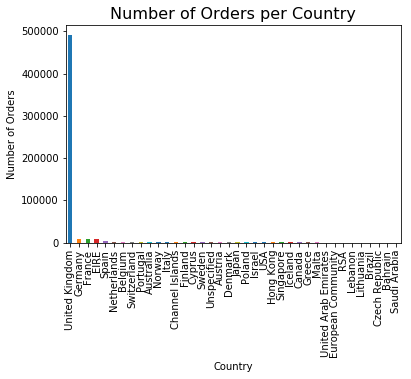

In [50]:
# Number of orders made by each country
# Inference - People from United Kingdom purchase the most 
total_orders=df.groupby('Country')['Quantity'].count().sort_values(ascending=False)
total_orders.plot('bar')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Country', fontsize=16)
plt.show()

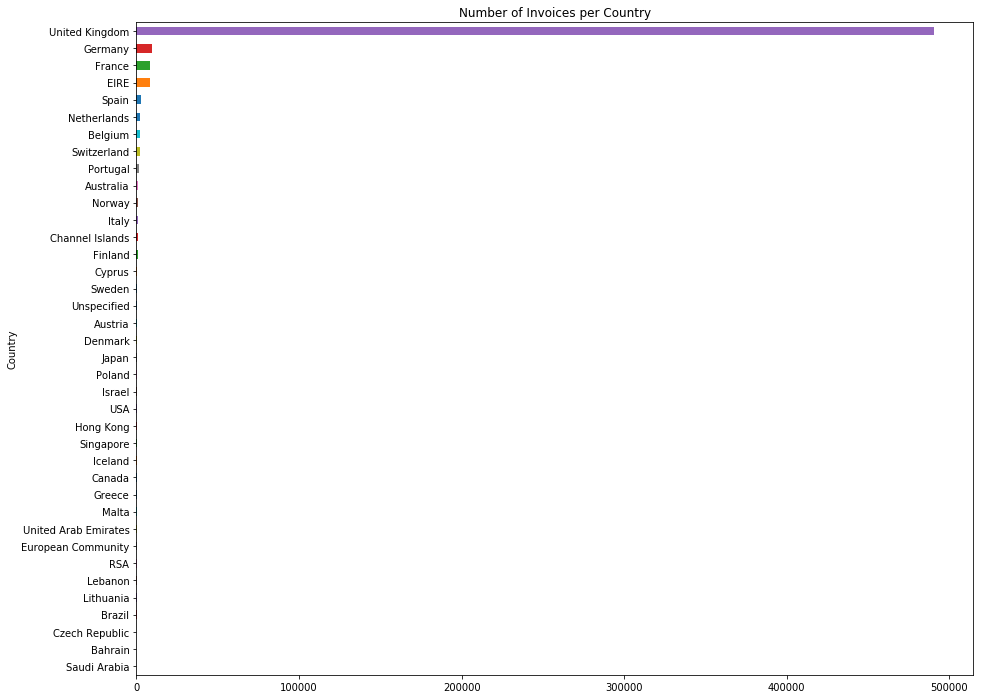

In [51]:
# No.of Invoices per country
No_invoice_per_country = df.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")
plt.show()

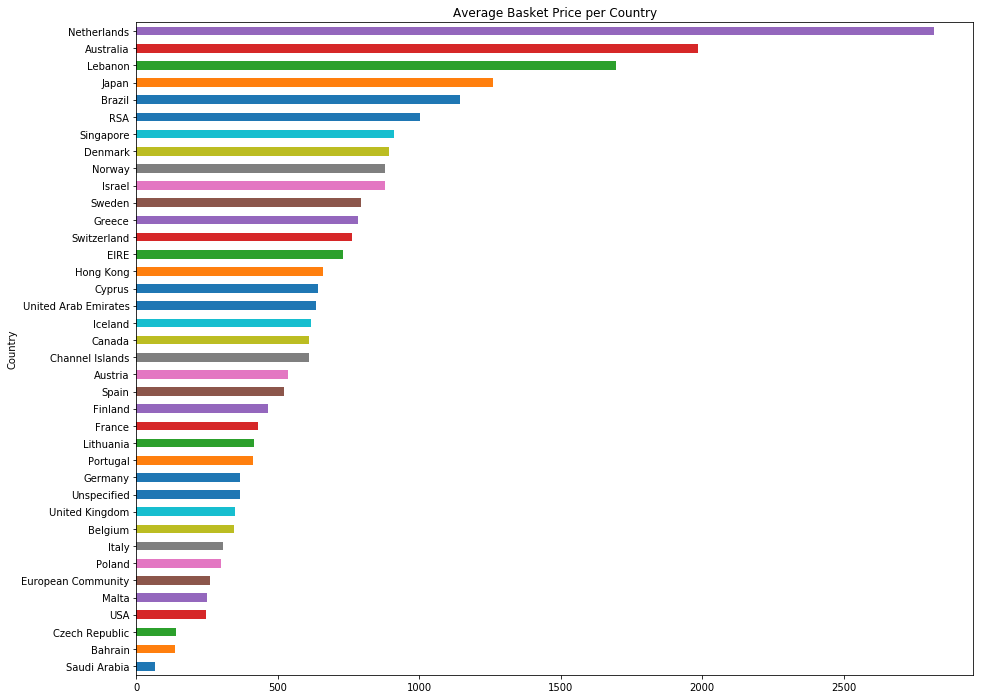

In [52]:
#Best Buyer with respect to country
best_buyer = df.groupby(["Country", "InvoiceNo"])["TotalPrice"].sum().reset_index().groupby(["Country"])["TotalPrice"].mean().sort_values()
best_buyer.plot(kind='barh', figsize=(15,12))
plt.title("Average Basket Price per Country")
plt.show()

#### 3. Exploratory Data Analysis with respect to Quantity

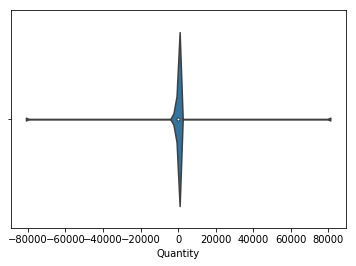

In [53]:
sns.violinplot(df.Quantity)

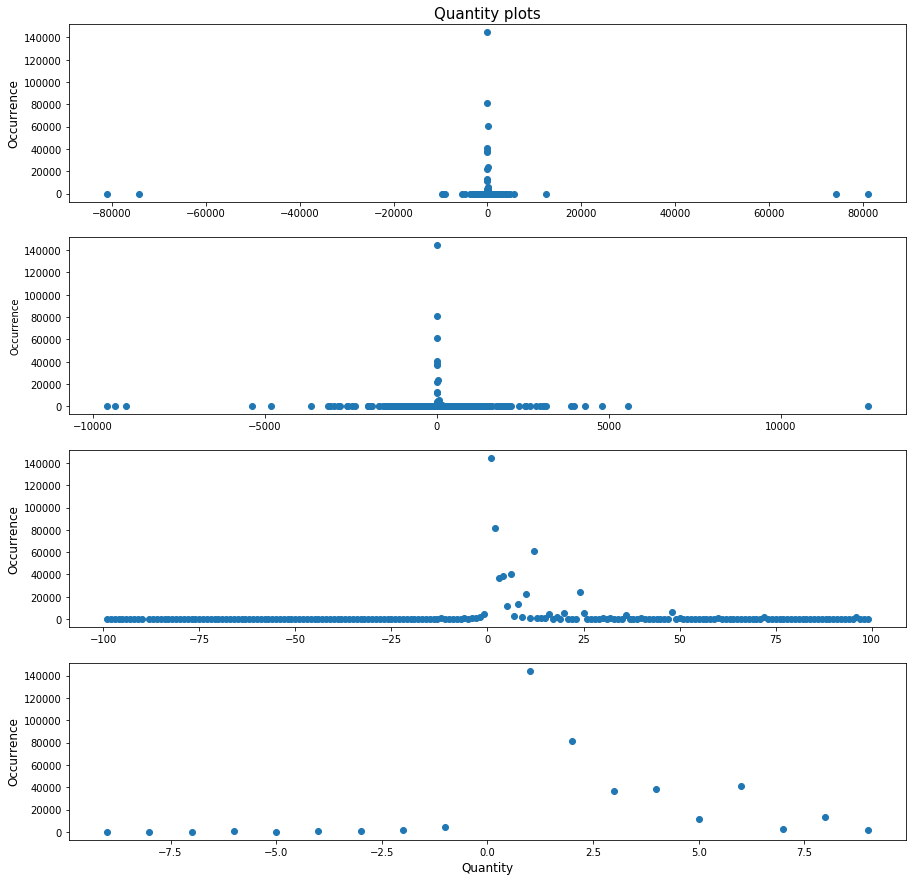

In [54]:
#visualising Quantity

plt.figure(figsize=(15,15))

x=df.Quantity.value_counts().reset_index().as_matrix().transpose()
plt.subplot(411) #1st digit #rows, 2nd digit #columns, 3rd digit plot number
plt.scatter(x[0], x[1], marker='o')
plt.title('Quantity plots',fontsize=15)
plt.ylabel('Occurrence',fontsize=12)

x=df[df['Quantity'].abs()<20000].Quantity.value_counts().reset_index().as_matrix().transpose()
plt.subplot(412)
plt.scatter(x[0], x[1], marker='o')
plt.ylabel('Occurrence')

#Based on 99th percentile
x=df[df['Quantity'].abs()<100].Quantity.value_counts().reset_index().as_matrix().transpose()
plt.subplot(413)
plt.scatter(x[0], x[1], marker='o')
plt.ylabel('Occurrence',fontsize=12)

#Based on 3rd quartile
x=df[df['Quantity'].abs()<10].Quantity.value_counts().reset_index().as_matrix().transpose()
plt.subplot(414)
plt.scatter(x[0], x[1], marker='o')
plt.xlabel('Quantity',fontsize=12)
plt.ylabel('Occurrence',fontsize=12)

plt.show()

In [55]:
#Identifying what is the equivalent counterpart while taking a look at the outliers and deleting them from dataset
df[df['Quantity'].abs()>50000]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,12346.0,United Kingdom,2011,1,18,10,77183.6
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,12346.0,United Kingdom,2011,1,18,10,-77183.6
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,16446.0,United Kingdom,2011,12,9,9,168469.6
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2.08,16446.0,United Kingdom,2011,12,9,9,-168469.6


In [56]:
#Removing the outliers
df.drop([61619, 61624, 540421, 540422], inplace=True)

In [57]:
#Identifying what is the equivalent counterpart while taking a look at the outliers.
df[(df['Quantity'].abs()>5000) & (df['Quantity'].abs()<50000)]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,TotalPrice
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,0.03,15838.0,United Kingdom,2010,12,2,14,-280.8
74614,542504,37413,NaN,5568,0.00,NaN,United Kingdom,2011,1,28,12,0.0
115818,546152,72140F,throw away,-5368,0.00,NaN,United Kingdom,2011,3,9,17,-0.0
225528,556687,23003,Printing smudges/thrown away,-9058,0.00,NaN,United Kingdom,2011,6,14,10,-0.0
225529,556690,23005,printing smudges/thrown away,-9600,0.00,NaN,United Kingdom,2011,6,14,10,-0.0
225530,556691,23005,printing smudges/thrown away,-9600,0.00,NaN,United Kingdom,2011,6,14,10,-0.0
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,0.00,13256.0,United Kingdom,2011,11,25,15,0.0


In [58]:
#Removing the outliers
df.drop([4287, 74614, 115818, 225528, 225529, 225530, 502122], inplace=True)

In [59]:
#Now lets check what is in our negative quantity
df[df["Quantity"]<=0].head(10)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,TotalPrice
141,C536379,D,Discount,-1,27.50,14527.0,United Kingdom,2010,12,1,9,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010,12,1,9,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010,12,1,10,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010,12,1,10,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010,12,1,10,-6.96
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010,12,1,10,-6.96
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,3.45,17548.0,United Kingdom,2010,12,1,10,-41.40
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,1.65,17548.0,United Kingdom,2010,12,1,10,-19.80
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,1.65,17548.0,United Kingdom,2010,12,1,10,-39.60
939,C536506,22960,JAM MAKING SET WITH JARS,-6,4.25,17897.0,United Kingdom,2010,12,1,12,-25.50


#### 4. Exploratory Data Analysis with respect to Unit Price (to find outliers)

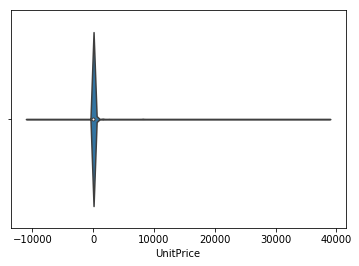

In [60]:
sns.violinplot(df.UnitPrice)

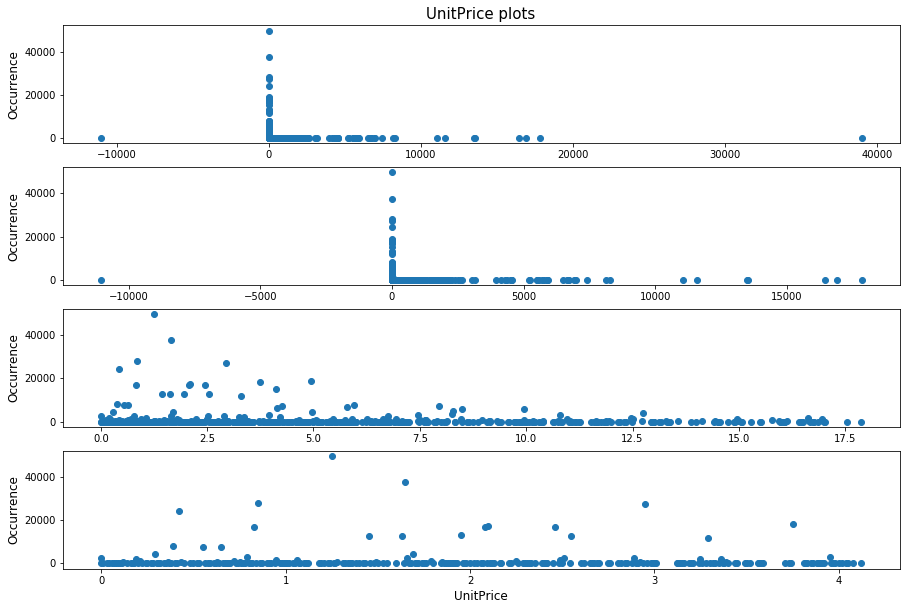

In [61]:
#plot price to see outliers

plt.figure(figsize=(15,10))

x=df.UnitPrice.value_counts().reset_index().as_matrix().transpose()
plt.subplot(411)
plt.scatter(x[0], x[1], marker='o')
plt.title('UnitPrice plots',fontsize=15)
plt.ylabel('Occurrence',fontsize=12)

x=df[df['UnitPrice'].abs()<20000].UnitPrice.value_counts().reset_index().as_matrix().transpose()
plt.subplot(412)
plt.scatter(x[0], x[1], marker='o')
plt.ylabel('Occurrence',fontsize=12)

#99th-percentile
x=df[df['UnitPrice'].abs()<18].UnitPrice.value_counts().reset_index().as_matrix().transpose()
plt.subplot(413)
plt.scatter(x[0], x[1], marker='o')
plt.ylabel('Occurrence',fontsize=12)

#3rd quartile
x=df[df['UnitPrice'].abs()<4.13].UnitPrice.value_counts().reset_index().as_matrix().transpose()
plt.subplot(414)
plt.scatter(x[0], x[1], marker='o')
plt.ylabel('Occurrence',fontsize=12)
plt.xlabel('UnitPrice',fontsize=12)

plt.show()

In [62]:
df[df['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Year,Month,Day,Hour,TotalPrice
299983,A563186,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011,8,12,14,-11062.06
299984,A563187,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011,8,12,14,-11062.06


In [63]:
df.drop([299983, 299984], inplace=True)

In [64]:
#We count the negative value of of quantity and Unit Price
print("The number of rows with negative Quantity:",sum(n < 0 for n in df.Quantity))
print("The number of rows with negative UnitPrice:",sum(n < 0 for n in df.UnitPrice))

The number of rows with negative Quantity: 10580
The number of rows with negative UnitPrice: 0


#### 5. Exploratory Data Analysis with respect to Customers and products

In [65]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4068,25887,4370


It can be seen that the data concern 4370 users and that they bought 4068 different products. The total number of transactions carried out is more than 21000

In [66]:
#Number of products purchased per customer
temp = df.groupby(by=['CustomerID'], as_index=False)['Quantity'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceNo':'Quantity'})
nb_products_per_basket.sort_values('Quantity', ascending=False)[:20]

,CustomerID,Quantity
4040,17841.0,7812
1893,14911.0,5898
1298,14096.0,5128
329,12748.0,4459
1672,14606.0,2759
2190,15311.0,2478
1701,14646.0,2085
567,13089.0,1853
696,13263.0,1667
1445,14298.0,1640


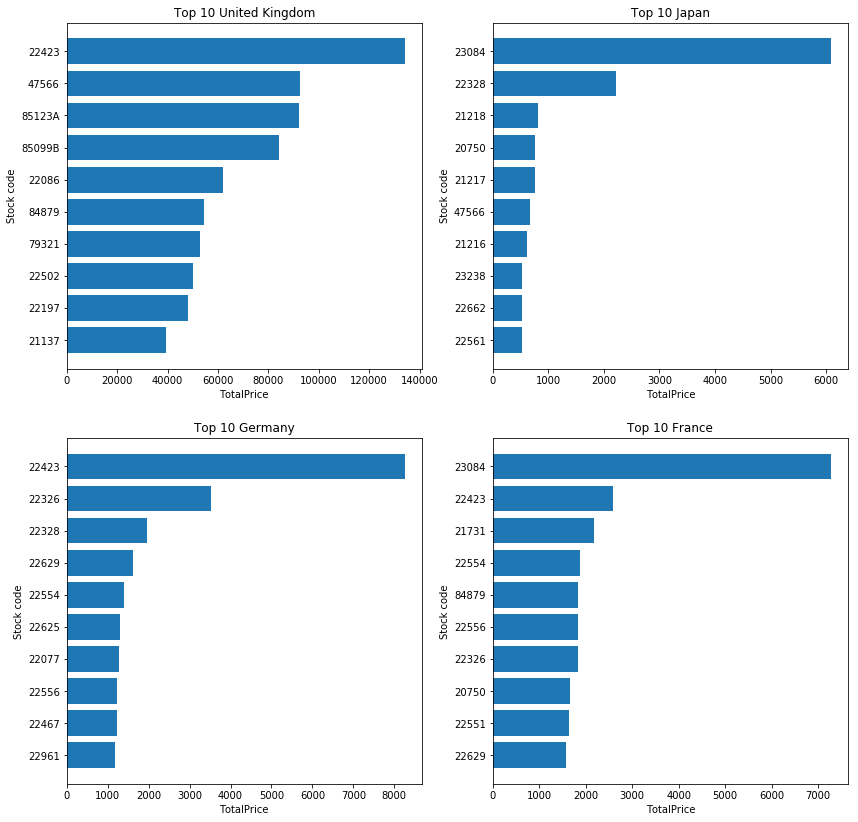

In [67]:
#Top selling products
grps = np.array([['Month', 'Week'], ['Hour', 'Minute']])
ctry = np.array([['United Kingdom', 'Japan'], ['Germany', 'France']])
fltr = ['DOT', 'POST', 'M']
top_n = 10

fig, ax = plt.subplots(grps.shape[0],grps.shape[1], figsize=(14, 14))

for i in range(0, ctry.shape[0]):
    for j in range(0, ctry.shape[1]):
        grp_data = df[df['Country'] == ctry[i,j]]
        grp_data = grp_data[~grp_data['StockCode'].isin(fltr)]
        grp_data = grp_data[['StockCode', 'TotalPrice']].groupby(['StockCode']).sum().sort_values(by='TotalPrice', ascending=False)        
        grp_data = grp_data[0:top_n]    
        grp_data = grp_data.reset_index()
        
        ax[i,j].barh(y=grp_data.index, width='TotalPrice', data=grp_data)
        ax[i,j].invert_yaxis()
        ax[i,j].set_yticks(range(0,top_n))
        ax[i,j].set_yticklabels(grp_data['StockCode'].tolist())
        ax[i,j].set_ylabel('Stock code')        
        ax[i,j].set_xlabel('TotalPrice')                
        ax[i,j].set_title('Top 10 ' + ctry[i,j])        
        
plt.show()

#### 6. Exploratory Data Analysis for Stock Code

In [68]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'S', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0055',
       'DCGS0072', 'DCGS0074', 'DCGS0069', 'DCGS0057', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'PADS', 'DCGS0004', 'DCGS0073',
       'DCGS0071', 'DCGS0068', 'DCGS0067', 'DCGS0066P', 'B', 'CRUK'],
      dtype=object)

In [69]:
#To check if the stock code is actually unique or not
df_stk=df.groupby("StockCode")['Description'].nunique().reset_index()
df_stockcode=df_stk[df_stk["Description"]>3]
df_stockcode

,StockCode,Description
173,20713,8
429,21181,5
711,21621,4
864,21823,4
870,21829,4
871,21830,6
1078,22121,4
1421,22501,4
1630,22719,4
1644,22734,4


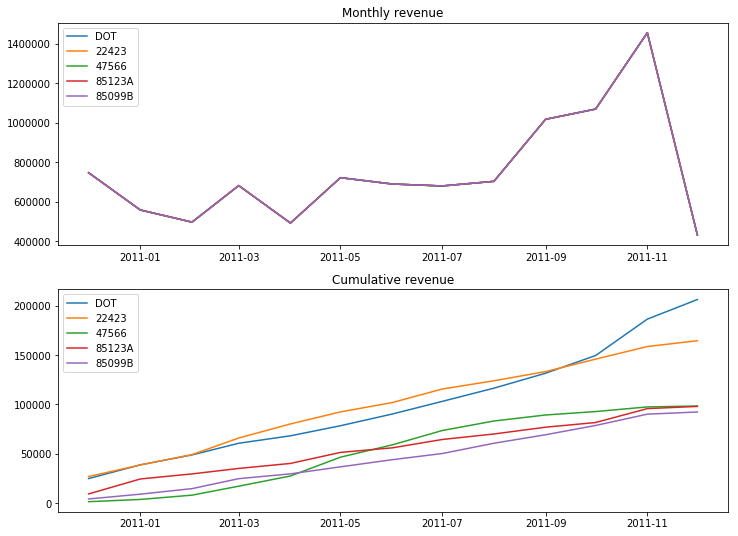

In [70]:
stock_top = df[['TotalPrice', 'StockCode']].groupby(['StockCode']).sum().reset_index().sort_values(by='TotalPrice', ascending=False)['StockCode'][0:5]

fig, ax = plt.subplots(2,1, figsize=(12, 9))

for c in stock_top:
    sales = df[df['StockCode'] == c]
    sales = df[['Year', 'Month', 'TotalPrice']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[0].plot(sales['TotalPrice'], label=c)
    ax[0].legend()
    ax[0].set_title('Monthly revenue')            

for c in stock_top:
    sales = df[df['StockCode'] == c]
    sales = sales[['Year', 'Month', 'TotalPrice']].groupby(['Year', 'Month']).sum().reset_index()
    sales['Day'] = 1
    sales['Date'] = pd.to_datetime(sales[['Year', 'Month', 'Day']])
    sales = sales.set_index('Date')
    sales = sales.drop(['Year', 'Month', 'Day'], axis=1)
    ax[1].plot(sales.cumsum(), label=c)
    ax[1].legend()
    ax[1].set_title('Cumulative revenue')       

#### 7. Exploratory Data Analysis of Time Stamp

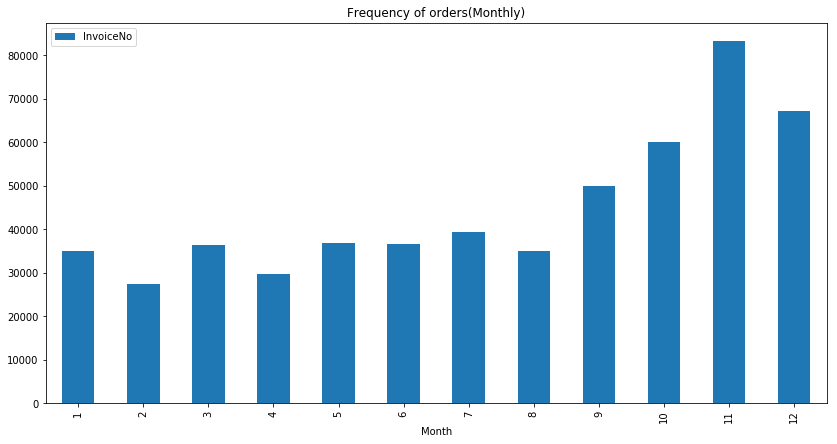

In [71]:
#
df.pivot_table(index=df['Month'],values='InvoiceNo',aggfunc=np.size).plot(kind='bar',
        figsize=(14,7),title='Frequency of orders(Monthly)');

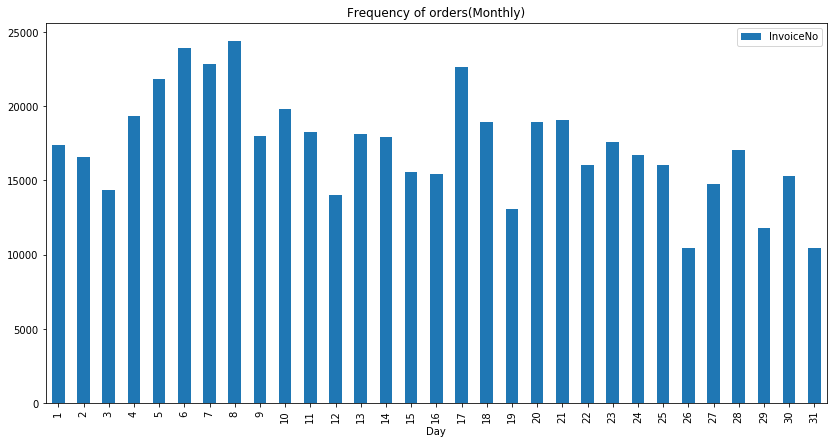

In [72]:
df.pivot_table(index=df['Day'],values='InvoiceNo',aggfunc=np.size).plot(kind='bar',
        figsize=(14,7),title='Frequency of orders(Monthly)');

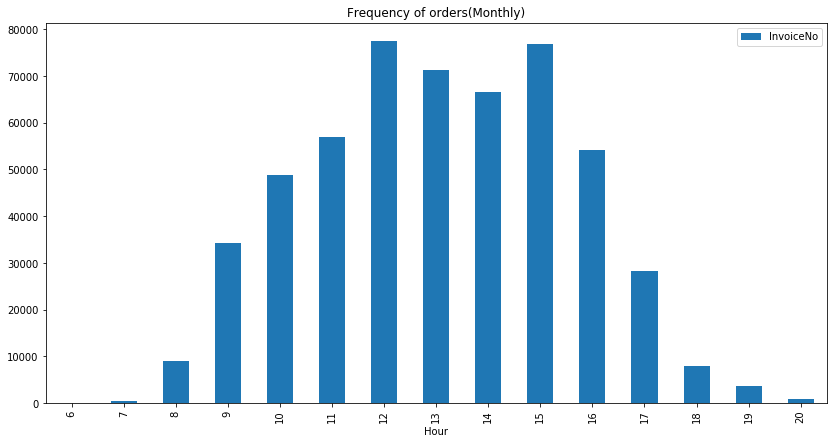

In [73]:
df.pivot_table(index=df['Hour'],values='InvoiceNo',aggfunc=np.size).plot(kind='bar',
        figsize=(14,7),title='Frequency of orders(Monthly)');

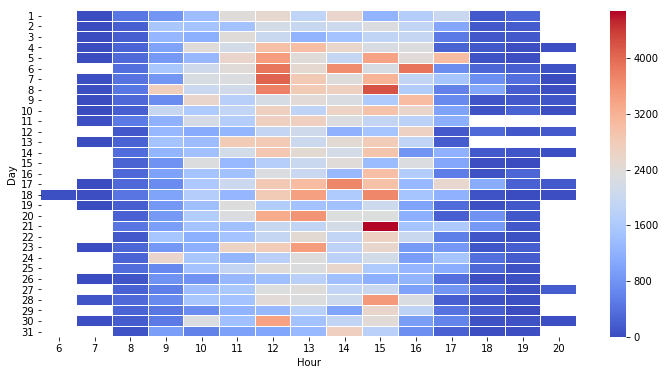

In [74]:
week_vs_hour = df.pivot_table(index=df['Day'],values='InvoiceNo',columns=df['Hour'],aggfunc=np.size)
plt.figure(figsize=(12,6))
sns.heatmap(week_vs_hour,cmap='coolwarm',linecolor='white',linewidths=0.01);

#### 8. Exploratory Data Analysis for Description

In [75]:
# Handle incorrect Description
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]
df = df[df["Description"].str.contains("LOST") == False]

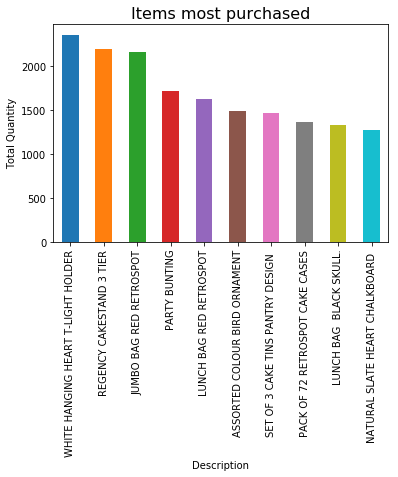

In [76]:
# Find the maximum purchased products
# Inference - White Hanging Herat T-Light Holder
high_descrip = df.groupby('Description')['Quantity'].count().sort_values(ascending=False)[:10]
high_descrip.plot('bar')
plt.xlabel('Description')
plt.ylabel('Total Quantity')
plt.title('Items most purchased', fontsize=16)
plt.show()

#### 8. Exploratory Data Analysis on Null Customer and imputing data

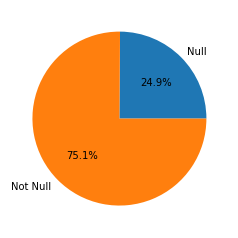

In [77]:
# Analysing the percentage of not null customers in the dataset. Inference - 25.2% Null, 74.8% Not Null
CustomerID_notnull = df.loc[~df['CustomerID'].isnull()] 
CustomerID_null = df.loc[df['CustomerID'].isnull()] 
pie_data = []
pie_data.append(len(CustomerID_null))
pie_data.append(len(CustomerID_notnull))
plt.pie(pie_data, labels=['Null', 'Not Null'], autopct='%1.1f%%',)
plt.show()

In [78]:
# To find from which country the maximum number of Null occurs
CustomerID_null.groupby(['Country']).size().sort_values(ascending=False)

Country
United Kingdom    130999
EIRE                 695
Hong Kong            278
Unspecified          201
Switzerland          117
France                66
Israel                47
Portugal              39
Bahrain                2
dtype: int64

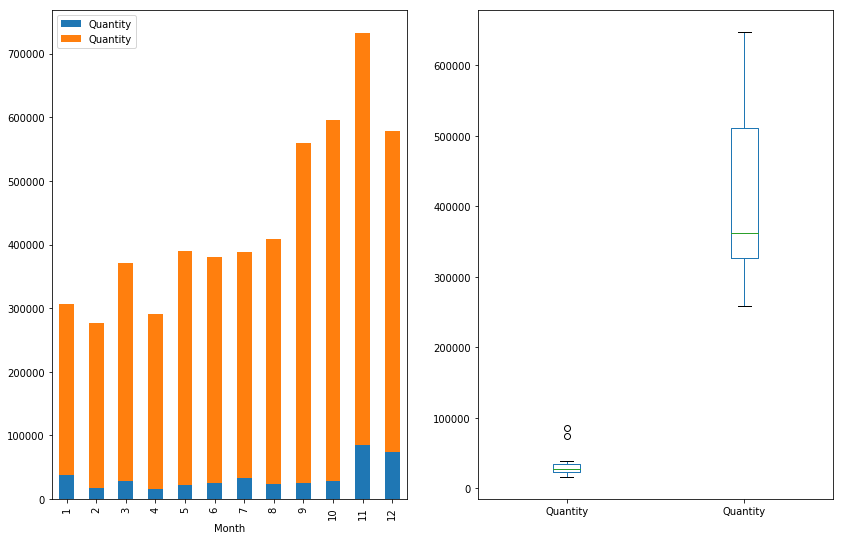

In [79]:
#To find the ratio of quantity of units purchased by null & not null customers
month_null = (CustomerID_null.groupby(['Month'])['Quantity'].sum())
month_notnull  = (CustomerID_notnull.groupby(['Month'])['Quantity'].sum())
month = pd.DataFrame([month_null, month_notnull]).transpose()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,9))
month.plot.bar(stacked=True, ax=axes[0])

month.plot.box(ax=axes[1])

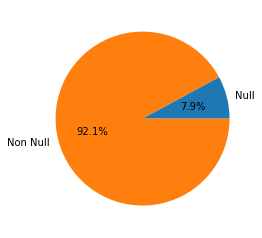

In [80]:
pie_data = []
pie_data.append(CustomerID_null['Quantity'].sum())
pie_data.append(CustomerID_notnull['Quantity'].sum())
plt.pie(pie_data, labels=['Null', 'Non Null'], autopct='%1.1f%%',)
plt.show()

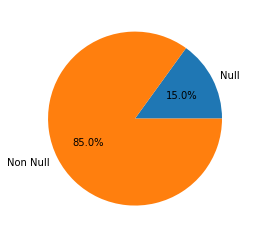

In [81]:
#To find the ratio of amount spent by null & not null customers
CustomerID_notnull['Total_Amount'] = CustomerID_notnull['Quantity']*CustomerID_notnull['UnitPrice']
CustomerID_null['Total_Amount'] = CustomerID_null['Quantity']*CustomerID_null['UnitPrice']
pie_data = []
pie_data.append(CustomerID_null['Total_Amount'].sum())
pie_data.append(CustomerID_notnull['Total_Amount'].sum())
plt.pie(pie_data, labels=['Null', 'Non Null'], autopct='%1.1f%%',)
plt.show()

In [82]:
# To analyse if any invoice intersects with the null/notnull CustomerID - Inference: None
intersect = pd.Series(np.intersect1d(CustomerID_null['InvoiceNo'].values, CustomerID_notnull['InvoiceNo'].values))
print(intersect.values)

[]


In [83]:
df["CustomerID"].fillna(df["InvoiceNo"], inplace=True)

## Model Training

### 1. Modifying categorical features

In [84]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
country_one_hot = encoder.fit_transform(df['Country'])
Y_onehot=country_one_hot

In [85]:
Y_onehot

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [86]:
from sklearn.preprocessing import LabelEncoder

y_en = LabelEncoder()
y_list = y_en.fit_transform(df["Country"])

In [87]:
y_list.shape

(532097,)

In [88]:
from sklearn.preprocessing import LabelEncoder
en = LabelEncoder()
df["Description_Code"] = en.fit_transform(df["Description"])

In [89]:
df.dtypes

InvoiceNo            object
StockCode            object
Description          object
Quantity              int64
UnitPrice           float64
CustomerID           object
Country              object
Year                  int64
Month                 int64
Day                   int64
Hour                  int64
TotalPrice          float64
Description_Code      int64
dtype: object

In [90]:
#Creating X_train dataset
d = {'Description': df['Description_Code'], 'Quantity': df['Quantity'], 'Unit Price': df['UnitPrice'], 'Month': df['Month'], 'Day': df['Day'], 'Hour': df['Hour']}

In [91]:
X=pd.DataFrame(d)

In [92]:
X

,Description,Quantity,Unit Price,Month,Day,Hour
0,3833,6,2.55,12,1,8
1,3841,6,3.39,12,1,8
2,885,8,2.75,12,1,8
3,1850,6,3.39,12,1,8
4,2833,6,3.39,12,1,8
5,3080,2,7.65,12,1,8
6,1474,6,4.25,12,1,8
7,1597,6,1.85,12,1,8
8,1594,6,1.85,12,1,8
9,226,32,1.69,12,1,8


In [93]:
X.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,Description,Quantity,Unit Price,Month,Day,Hour
Description,1.0,0.0042,-0.015,0.011,0.0046,-0.0061
Quantity,0.0042,1.0,-0.0085,-0.007,-0.0025,-0.065
Unit Price,-0.015,-0.0085,1.0,0.00079,-0.0034,0.0014
Month,0.011,-0.007,0.00079,1.0,-0.12,0.026
Day,0.0046,-0.0025,-0.0034,-0.12,1.0,-0.00017
Hour,-0.0061,-0.065,0.0014,0.026,-0.00017,1.0


#### Implementing Supervised Machine Learning Classification Algorithms

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#Splitting the dataset: 75% train, 25% test
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(X, Y_onehot, random_state = 0)

In [95]:
X_train_list, X_test_list, y_train_list, y_test_list = train_test_split(X, y_list, random_state = 0)

In [97]:
print(X_train_onehot.shape)
print(y_train_onehot.shape)
print(X_test_onehot.shape)
print(y_test_onehot.shape)

(399072, 6)
(399072, 38)
(133025, 6)
(133025, 38)


In [98]:
print(X_train_list.shape)
print(y_train_list.shape)
print(X_test_list.shape)
print(y_test_list.shape)

(399072, 6)
(399072,)
(133025, 6)
(133025,)


In [69]:
#K-NN

training_accuracy=[]
test_accuracy=[]
neighbours=range(1,3)

for value in neighbours:
    knn_model = KNeighborsClassifier(n_neighbors = value).fit(X_train, y_train)
    training_accuracy = knn_model.score(X_train, y_train)
    test_accuracy = knn_model.score(X_test, y_test)
    print(training_accuracy)
    print(test_accuracy)

# # creating a confusion matrix 
# knn_predictions = knn_model.predict(X_test)  
# knn_cm = confusion_matrix(y_test, knn_predictions) 

# plt.plot(neighbours, training_accuracy, label="training accuarcy")
# plt.plot(neighbours, test_accuracy, label="test accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("n_neighbours")
# plt.legend()

0.9972561342314169
0.873873332080436
0.8739375350813888
0.8119075361774103


In [106]:
#Decision Tree
decision_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train) 
decision_predictions = decision_model.predict(X_test) 
  
#Returning accuracy score
decision_accuracy = accuracy_score(y_test, decision_predictions)

# # creating a confusion matrix 
# decision_cm = confusion_matrix(y_test, decision_predictions) 

print(decision_accuracy)
# print(decision_cm)

0.9126705506483743


In [ ]:
# Support Vector Machine
y_train_svm = np.argmax(y_train, axis=1)
y_test_svm = np.argmax(y_test, axis=1)

svm_model= SVC(kernel = 'linear', C=1).fit(X_train, y_train_svm) 
svm_predictions = svm_model.predict(X_test) 
  
# model accuracy for X_test   
svm_accuracy = svm_model.score(X_test, y_test)  
# # creating a confusion matrix 
# svm_cm = confusion_matrix(y_test, svm_predictions) 

print(svm_accuracy)
# print(svm_cm)

In [ ]:
#Naive-Bayes

nb_model = GaussianNB().fit(X_train_list, y_train_list) 
gnb_predictions = nb_model.predict(X_test) 

# accuracy on X_test 
nb_accuracy = nb_model.score(X_test_list, y_test_list) 
print(nb_accuracy) 

# creating a confusion matrix 
# nb_cm = confusion_matrix(y_test, gnb_predictions) 

In [ ]:
#Implementing Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train_list, y_train_list)
y_pred = logreg.predict(X_test_list)
print(metrics.accuracy_score(y_test_list, y_pred))

In [ ]:
#Implementing Random Forest
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)  
regressor.fit(X_train, y_train)  
y_pred = regressor.predict(X_test)  
print(metrics.accuracy_score(y_test, y_pred))